# Waveguide Y junction

Power splitters such as Y-junctions are widely used in photonic integrated circuits across different applications. When designing a power splitter, we aim to achieve a flat broadband response, low insertion loss, and compact footprint. At the same time, the design needs to comply with the fabrication resolution and tolerance.

In this example, we demonstrate the modeling of a Y-junction for integrated photonics. The designed device shows an average insertion loss below 0.2 dB in the wavelength range of 1500 nm to 1600 nm. At the same time, it has a small footprint. The junction area is smaller than 2 $\mu m$ by 2 $\mu m$, much smaller than the typical power splitters based on multimode interference devices. The design is adapted from [Yi Zhang, Shuyu Yang, Andy Eu-Jin Lim, Guo-Qiang Lo, Christophe Galland, Tom Baehr-Jones, and Michael Hochberg, "A compact and low loss Y-junction for submicron silicon waveguide," Opt. Express 21, 1310-1316 (2013)](https://opg.optica.org/oe/fulltext.cfm?uri=oe-21-1-1310).

<img src="img/y_junction_schematic.png" width="600" alt="Schematic of the waveguide Y junction">

For more integrated photonic examples such as the [8-Channel mode and polarization de-multiplexer](https://www.flexcompute.com/tidy3d/examples/notebooks/8ChannelDemultiplexer/), the [broadband bi-level taper polarization rotator-splitter](https://www.flexcompute.com/tidy3d/examples/notebooks/BilevelPSR/), and the [broadband directional coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/BroadbandDirectionalCoupler/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gdstk

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

## Simulation Setup  

Define simulation wavelength range to be 1.5 $\mu m$ to 1.6 $\mu m$.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

In this model, the Y-junction is made of silicon. The top cladding is made of silicon oxide. We will directly use the silicon and oxide media from Tidy3D's [material library](../api/material_library.html#). More specifically, we use the data from the widely used Handbook of Optical Constants of Solids by Palik. 

In [3]:
si = td.material_library["cSi"]["Palik_Lossless"]

sio2 = td.material_library["SiO2"]["Palik_Lossless"]

The junction is discretized into 13 segments. Each segment is a tapper with the given widths. The optimum design is obtained by optimizing the 13 width parameters using the Particle Swarm Optimization algorithm. For the sake of simplicity, in this notebook, we skip the optimization procedure and only present the optimized result.

In [4]:
t = 0.22  # thickness of the silicon layer

# width of the 13 segments
w1 = 0.5
w2 = 0.5
w3 = 0.6
w4 = 0.7
w5 = 0.9
w6 = 1.26
w7 = 1.4
w8 = 1.4
w9 = 1.4
w10 = 1.4
w11 = 1.31
w12 = 1.2
w13 = 1.2

l_in = 1  # input waveguide length
l_junction = 2  # length of the junction
l_bend = 6  # horizontal length of the waveguide bend
h_bend = 2  # vertical offset of the waveguide bend
l_out = 1  # output waveguide length
inf_eff = 100  # effective infinity

First, define the junction structure by using a [PolySlab](../api/_autosummary/tidy3d.PolySlab.html). The vertices are given by the widths of the segments defined above. If a smooth curve is desirable, one can interpolate the vertices to a finer grid using spline for example. 

Before proceeding further to construct other structures, we can use the `plot` method to inspect the geometry. 

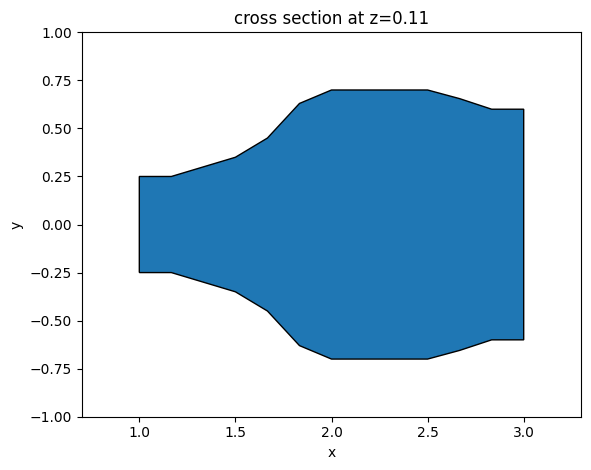

In [5]:
x = np.linspace(l_in, l_in + l_junction, 13)  # x coordinates of the top edge vertices
y = np.array(
    [w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13]
)  # y coordinates of the top edge vertices

# using concatenate to include bottom edge vertices
x = np.concatenate((x, np.flipud(x)))
y = np.concatenate((y / 2, -np.flipud(y / 2)))

# stacking x and y coordinates to form vertices pairs
vertices = np.transpose(np.vstack((x, y)))

junction = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t)), medium=si
)
junction.plot(z=t / 2)
plt.show()

For the output waveguide bends, we use S bend sine waveguides, which are described by the function
<center>$y = \frac{xh_{band}}{l_{bend}}-\frac{h_{bend}}{2\pi}sin(\frac{2\pi x}{l_{bend}})$.</center>

Different types of bend can also be used here for similar performance. To define the bends, the most convenient way is to use `gdstk`. First compute the $x$ and $y$ coordinates of the bend, then define a `FlexPath` and add it to a gds cell. The paths in the cell can be converted to Tidy3D [PolySlabs](../api/_autosummary/tidy3d.PolySlab.html) using the `from_gds` method.

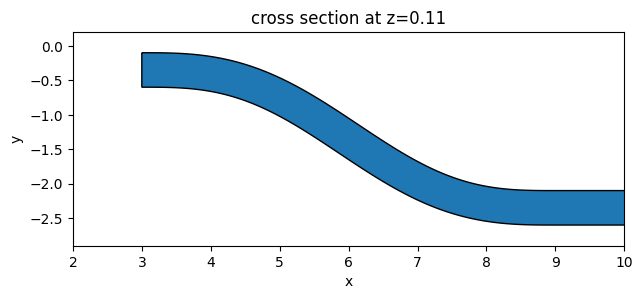

In [6]:
x_start = l_in + l_junction  # x coordinate of the starting point of the waveguide bends

x = np.linspace(x_start, x_start + l_bend, 100)  # x coordinates of the top edge vertices

y = (
    (x - x_start) * h_bend / l_bend
    - h_bend * np.sin(2 * np.pi * (x - x_start) / l_bend) / (np.pi * 2)
    + w13 / 2
    - w1 / 2
)  # y coordinates of the top edge vertices

# adding the last point to include the straight waveguide at the output
x = np.append(x, inf_eff)
y = np.append(y, y[-1])

# add path to the cell
cell = gdstk.Cell("bends")
cell.add(gdstk.FlexPath(x + 1j * y, w1, layer=1, datatype=0))  # top waveguide bend
cell.add(gdstk.FlexPath(x - 1j * y, w1, layer=1, datatype=0))  # bottom waveguide bend

# define top waveguide bend structure
wg_bend_1 = td.Structure(
    geometry=td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(0, t),
    )[0],
    medium=si,
)

# define bottom waveguide bend structure
wg_bend_2 = td.Structure(
    geometry=td.PolySlab.from_gds(
        cell,
        gds_layer=1,
        axis=2,
        slab_bounds=(0, t),
    )[1],
    medium=si,
)

# plot the top waveguide bend to visualize
ax = wg_bend_1.plot(z=t / 2)
ax.set_xlim(2, 10)
plt.show()

Lastly, define the straight input waveguide using [Box](../api/_autosummary/tidy3d.Box.html).

In [7]:
# straight input waveguide
wg_in = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -w1 / 2, 0), rmax=(l_in, w1 / 2, t)),
    medium=si,
)

# the entire model is the collection of all structures defined so far
y_junction = [wg_in, junction, wg_bend_1, wg_bend_2]

Define the simulation domain. Here we ensure sufficient buffer spacing in each direction. In general, we want to make sure that the structure is at least half a wavelength away from the domain boundaries unless it goes into the PML.

In [8]:
Lx = l_in + l_junction + l_out + l_bend  # simulation domain size in x direction
Ly = w13 + 2 * h_bend + 1.5 * lda0  # simulation domain size in y direction
Lz = 10 * t  # simulation domain size in z direction
sim_size = (Lx, Ly, Lz)

We will use a [ModeSource](../api/_autosummary/tidy3d.ModeSource.html) to excite the input waveguide using the fundamental TE mode. 

A [ModeMonitor](../api/_autosummary/tidy3d.ModeMonitor.html) is placed at the top output waveguide to measure the transmission. A [FieldMonitor](../api/_autosummary/tidy3d.FieldMonitor.html) is added to the xy plane to visualize the power flow.

In [9]:
# add a mode source as excitation
mode_spec = td.ModeSpec(num_modes=1, target_neff=3.5)
mode_source = td.ModeSource(
    center=(l_in / 2, 0, t / 2),
    size=(0, 4 * w1, 6 * t),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# add a mode monitor to measure transmission at the output waveguide
mode_monitor = td.ModeMonitor(
    center=(l_in + l_junction + l_bend + l_out / 2, w13 / 2 - w1 / 2 + h_bend, t / 2),
    size=(0, 4 * w1, 6 * t),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

# add a field monitor to visualize field distribution at z=t/2
field_monitor = td.FieldMonitor(
    center=(0, 0, t / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

Set up the simulation with the previously defined structures, source, and monitors. All boundaries are set to PML to mimic infinite open space. Since the top and bottom claddings are silicon oxide, we will set the medium of the background to silicon oxide. 

In principle, we can impose symmetry to reduce the computational load. Since this model is relatively small and quick to solve, we will simply model the whole device without using symmetry.

Using an [automatic nonuniform grid](https://www.flexcompute.com/tidy3d/examples/notebooks/AutoGrid/) is the most efficient and convenient. We set `min_steps_per_wvl=20` to achieve a very accurate result while still keeping the simulation cost at a minimum.

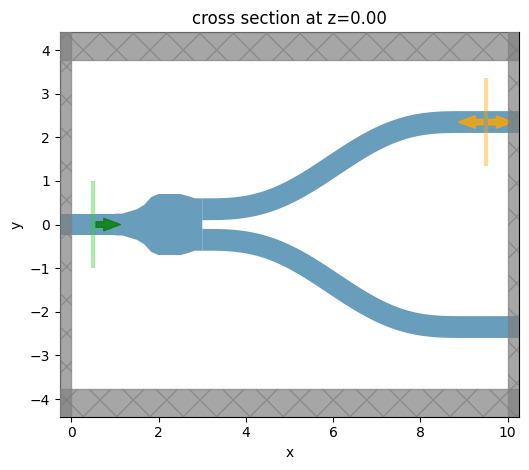

In [10]:
run_time = 5e-13  # simulation run time

# construct simulation
sim = td.Simulation(
    center=(Lx / 2, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=y_junction,
    sources=[mode_source],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
)

sim.plot(z=0)
plt.show()

To have a better visualization, we can also plot the simulation in 3D.

In [11]:
sim.plot_3d()

Before submitting the simulation to the server, it is a good practice to visualize the mode profile at the [ModeSource](../api/_autosummary/tidy3d.ModeSource.html) to ensure we are launching the fundamental TE mode. To do so, we will use the [ModeSolver](../api/_autosummary/tidy3d.plugins.mode.ModeSolver.html) plugin, which solves for the mode profile on your local computer.

In [12]:
mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(center=mode_source.center, size=mode_source.size),
    mode_spec=mode_spec,
    freqs=[freq0],
)
mode_data = mode_solver.solve()

02:40:32 PST WARNING: Use the remote mode solver with subpixel averaging for    
             better accuracy through 'tidy3d.plugins.mode.web.run(...)'.        

Visualize the mode profile. We confirm that we are exciting the waveguide with the fundamental TE mode.

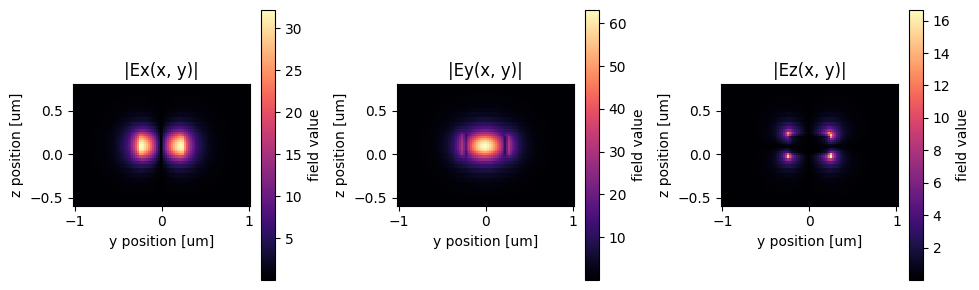

In [13]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
abs(mode_data.Ex.isel(mode_index=0)).plot(x="y", y="z", ax=ax1, cmap="magma")
abs(mode_data.Ey.isel(mode_index=0)).plot(x="y", y="z", ax=ax2, cmap="magma")
abs(mode_data.Ez.isel(mode_index=0)).plot(x="y", y="z", ax=ax3, cmap="magma")

ax1.set_title("|Ex(x, y)|")
ax1.set_aspect("equal")
ax2.set_title("|Ey(x, y)|")
ax2.set_aspect("equal")
ax3.set_title("|Ez(x, y)|")
ax3.set_aspect("equal")
plt.show()

Now that we verified all the settings, we are ready to submit the simulation job to the server. Before running the simulation, we can get a cost estimation using `estimate_cost`. This prevents us from accidentally running large jobs that we set up by mistake. The estimated cost is the maximum cost corresponding to running all the time steps.

In [14]:
job = web.Job(simulation=sim, task_name="y_junction", verbose=True)
estimated_cost = web.estimate_cost(job.task_id)

02:40:33 PST Created task 'y_junction' with task_id                             
             'fdve-6610bed9-b56a-43e1-abd2-44505d702c7b' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=717825;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6610bed9-b56a-43e1-abd2-44505d702c7b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=304476;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6610bed9-b56a-43e1-abd2-44505d702c7b\taskId]8;;\]8;id=717825;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6610bed9-b56a-43e1-abd2-44505d702c7b\=]8;;\]8;id=428746;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6610bed9-b56a-43e1-abd2-44505d702c7b\fdve]8;;\]8;id=717825;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6610bed9-b56a-43e1-abd2-44505d702c7b\-6610bed9-b56]8;;\
             ]8;id=717825;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6610bed9-b56a-43e1-abd2-44505d702c7b\a-43e1-abd2-44505d702c7b']8;;\.

Output()

             Maximum FlexCredit cost: 0.112. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

The cost is reasonaly so we can run the simulation.

In [15]:
sim_data = job.run(path="data/simulation_data.hdf5")

02:40:34 PST status = queued

Output()

02:40:40 PST status = preprocess

02:40:41 PST Maximum FlexCredit cost: 0.112. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

02:41:28 PST early shutoff detected at 76%, exiting.

             status = postprocess

Output()

02:41:32 PST status = success

             View simulation result at                                          
             ]8;id=342409;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6610bed9-b56a-43e1-abd2-44505d702c7b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=62385;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6610bed9-b56a-43e1-abd2-44505d702c7b\taskId]8;;\]8;id=342409;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6610bed9-b56a-43e1-abd2-44505d702c7b\=]8;;\]8;id=315700;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6610bed9-b56a-43e1-abd2-44505d702c7b\fdve]8;;\]8;id=342409;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6610bed9-b56a-43e1-abd2-44505d702c7b\-6610bed9-b56]8;;\
             ]8;id=342409;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6610bed9-b56a-43e1-abd2-44505d702c7b\a-43e1-abd2-44505d702c7b']8;;\.

Output()

02:41:33 PST loading simulation from data/simulation_data.hdf5

             WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

## Result Visualization 

After the simulation is complete, we first inspect the insertion loss. Within this wavelength range, we see that the insertion loss is generally below 0.2 dB.

02:41:34 PST WARNING: Monitor data requires 'grid_expanded' to be defined to    
             compute values like flux, Poynting and dot product with other data.

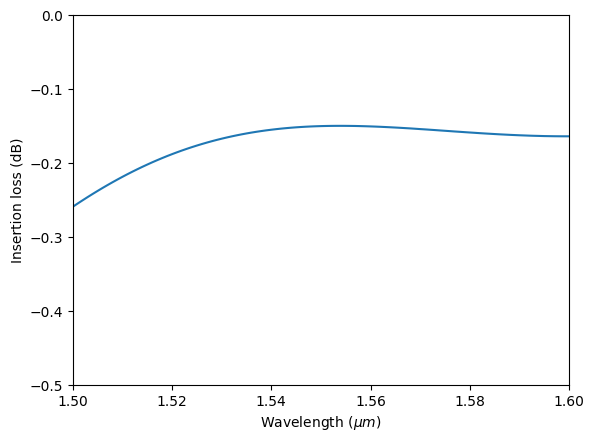

In [16]:
# extract the transmission data from the mode monitor
amp = sim_data["mode"].amps.sel(mode_index=0, direction="+")
T = np.abs(amp) ** 2

plt.plot(ldas, 10 * np.log10(2 * T))
plt.xlim(1.5, 1.6)
plt.ylim(-0.5, 0)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Insertion loss (dB)")
plt.show()

We can also visualize the field distribution. Here we can see the interference in the junction while no visible higher order modes are excited at the output waveguides.

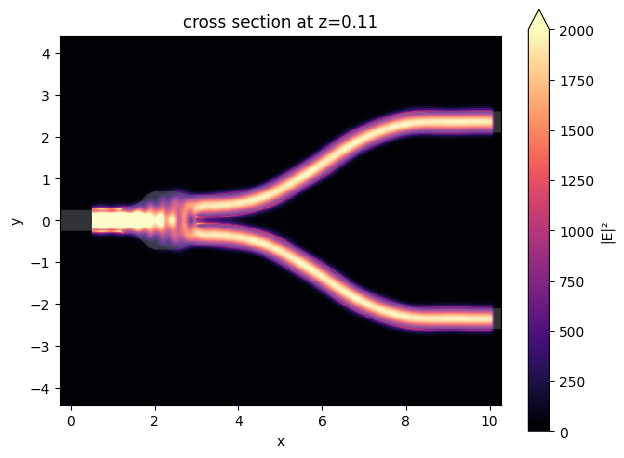

In [17]:
sim_data.plot_field(
    field_monitor_name="field", field_name="E", val="abs^2", f=freq0, vmin=0, vmax=2e3
)
plt.show()